COMP 215 - LAB 5 (Elementary Cellular Automata)
-----------------------------------------------
#### Name: Sos & Roberto
#### Date: 02/06/2023

This lab exercise is an introduction to the elementary [Cellular Automata](https://en.wikipedia.org/wiki/Elementary_cellular_automaton) studied by [Stephen Wolfram](https://en.wikipedia.org/wiki/Stephen_Wolfram#Complex_systems_and_cellular_automata).

**New Python concepts**:
  * **[NumPy](https://numpy.org)** is an open-source scientific computing package.  We will be using numpy for the remainder of the term.
  * 1D and 2D [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) -  an rectangular grid with efficient matrix operations.

**New Computation concepts**:
  * **bit sequence** (a.k.a. binary number) - using a sequence of 0's and 1's to efficiently represent a data structure and processes.

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random 
%matplotlib inline

## CA Fundamentals
Both the textbook and our week5 notebook develop some fundamental operations for simulating Elementary CA.
Some of the code from `week5.ipynb` is reproduced here without deriving all the ideas - review `week5.ipynb` notebook for the full story.
The sliding dot product algorithm in `rule_indexes` is implemented with [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html).  It's behaviour is identical to the derivation in `week5.ipynb`.

#### Notes
* we use `np.pad(array, 1, mode='wrap')` to pad state vector with 1 value on either end from the opposite end of the vector.
* since the rule is an `np.array`, we use "vector indexing" here to index a whole row at once:  next_row=rule[indexes]


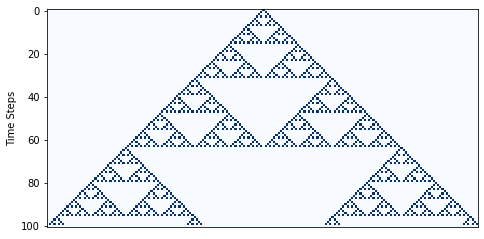

In [2]:
POWERS_OF_2 = np.array((4, 2, 1))

def rule_indexes(state):
    """ Return vector of rule indexes - one index for each 3-cell neighbourhood in the CA state vector. """
    # numpy's version of the "sliding dot product" algorithm;  "pad" ends of state array with extra 0 cell to mitigate edge effects
    return np.correlate(np.pad(state, 1, mode='constant'), POWERS_OF_2, mode='valid')

assert all( rule_indexes(np.array([1,1,0,0,1,0,0,0])) == [3, 6, 4, 1, 2, 4, 0, 0] )


def transition(state, rule):
    """ Return a np.array for the state transition for given CA state under the given 8-bit rule """
    indexes = rule_indexes(state)
    return np.array(rule[indexes])  # "vector indexing" replaces: [rule[i] for i in indexes]

rule_110 = (0,1,1,0,1,1,1,0)[::-1]
assert all( transition(np.array((0,0,1,1,1,0,0,0,1,1,0)), np.array(rule_110)) == (0,1,1,0,1,0,0,1,1,1,0))


# This algorithm is from the textbook - it uses numpy to do a decimal to binary conversion.
def get_lookup_table(rule):
    """
    Return the 8-bit transition vector for the given elementary CA rule number.
    rule: int 0-255
    returns: transition lookup table - a 8 element vector of 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    return np.unpackbits(rule)[::-1]

assert np.all( get_lookup_table(110) == rule_110 )


def single_centre_array(n_cells):
    """ Return a binary 1D array with given number of cells, all zeros except a single 1 in the centre cell """
    array = np.zeros(n_cells, dtype=np.uint8)
    array[n_cells//2] = 1
    return array

assert np.all( single_centre_array(7) == (0,0,0,1,0,0,0) )


def simulate_ca(n_cells, n_steps, rule):
    """ Generate a CA with given number of cells, plot progression of rule for given number of time steps """
    start_state = single_centre_array(n_cells)
    # stack up one "empty" state vector for each time step
    ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
    for t in range(1, n_steps):
        ca_timesteps[t] = transition(ca_timesteps[t-1], rule)
    return ca_timesteps


def plot_ca(array, title=''):
    """ Plot the 2D CA array as an image.  1's will be dark blue, 0's will be light blue. """
    plt.title(title)
    plt.xticks([])  # turn off x-axis tick marks
    plt.ylabel('Time Steps')  # label y-axis to remind us time runs from top to bottom
    plt.imshow(array, cmap='Blues', interpolation='none')


rule_90 = get_lookup_table(90)
ca_timesteps = simulate_ca(200, 100, rule_90)
plt.subplots(figsize=(8, 4))
plot_ca(ca_timesteps)

## Exercise 1: Additional Start States
In Wolfram's original experiments, he starts with a CA that is all zeros except the centre cell.
This is reproduced by the `single_centre_array` function above.
It would be interesting to experiment with other start states...

Write 2 functions, each of which returns a 1-D `numpy.array` (vector) configured in a specific state:
1. `from_string_array` takes a text string of 0's and 1's and returns a 1D array with matching integer values
2. `random_array` takes a float $ p where 0 <= p <= 1 $ as input and returns a 1D array $a$, where probability $a[i] == 1$ is $p$

*Tip*: both problems are most easilty solved using list comprehensions!

In [23]:
# Solution for Ex. 1 here...
# def from_string_array(state_str):
#   array = np.array([], dtype=np.uint8)
#   np.append(array, int(char) for char in state_str)
#   return array

def from_string_array(state_str):
  array = np.array([int(char) for char in state_str], dtype=np.uint8)
  return array

def random_array(p, n_cells):

  array = np.array([1 if random.random() < p else 0  for i in range(n_cells)], dtype=np.uint8)
  return array

[0 0 0 0 0 0 1 0 0 1]


## Exercise 2: A Cell1D class
Develop your own Cell1D class that uses the functions above to implement its fundamental operations.
The `Cell1D` class from the textbook may provide some ideas, but you may find it more confusing than helpful.
The goal here is to improve on the design of that class, so it might be better to just start over...

* Initialize a Cell1D with a `rule` number and an array representing the CA `start_state`
  *Tip*: initialize a 2-D array with just a single row to define the CA's data structure correctly.
* Add a `simulate` method that takes the number of steps to simulate as input (note: my solution is just 4 lines of code)
  *Tip*: use `vstack` to add enough rows onto the CA array prior to looping the simulation forward the given number of steps.
  *Tip*: watch your indexing logic - each subsequent call must start where the last one left off.  There is an elegant solution to this.
* Add a `step` method.  Unlike the textbook, our `step` method is just a convenience method - it just `simulate`s a single step.
* Add a `draw` method.  You could either call on `plot_ca` to do the actual work or copy its code in - your choice.

Note: this is *not* a dataclass - you will need to initialzice objects with an `__init__` method.

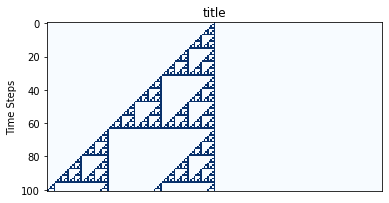

In [85]:
# Solution for Ex. 2 here...
class Cell1D:
  """ An Elementary 1D Cellular Automata """
  state : np.array
  rule : int

  def __init__(self, start_state, rule):
    """ Construct CA with given start_state vector and Wolfram rule number """
    self.state = [from_string_array(start_state)]
    self.rule = get_lookup_table(rule)

  def simulate(self, n_steps):
    """ Simulate this CA forward the given number of time steps """
    for i in range(n_steps):
      self.state.append(transition(self.state[i], self.rule))

  def step(self):
    """ Step the simulation 1 step forward """
    self.simulate(1)
    
  def draw(self):
    """ Plot a visualization of the CA simulation """
    plot_ca(self.state, "title")

ca = Cell1D(single_centre_array(201), 102)
ca.simulate(100)
ca.draw()

## Exercise 3: Run some Experiments
With your new Cell1D class, run some experiments to explore the Elementary CA's.

Wolfram identifies 4 "classes" of Elementary Cellular Automata:
    a) rapidly converge to a uniform static state.
    b) rapidly converge to a stable repeating pattern.
    c) generate non-repeating, random states.
    d) generate chaos, with areas of repetitive or stable states, but also structures that interact in complex ways.

### Exercises

1. It will be convenient to abstract the steps needed to construct, simulate, and draw a CA - develop a small `experiment` function to do so.

2. Identify a rule that exemplifies each of the 4 CA classes.
   Create a 2x2 grid of plots that shows an example simulation for each class of CA side-by-side.

In [5]:
# Solution for Ex. 3 here...


#### Example code for creating grid of plots:

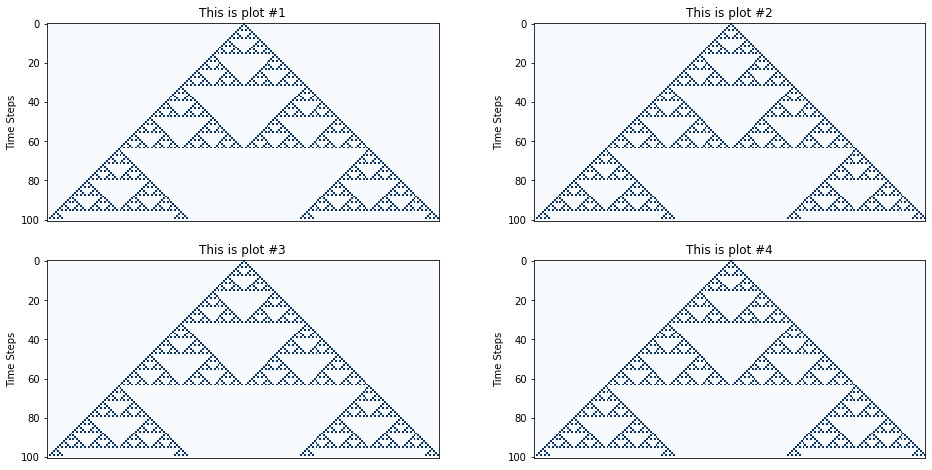

In [6]:
plt.subplots(figsize=(16, 8))   # total figure size for subplots is 16 x 8 inches
# Example: plot 4 plots in a 2x2 grid - plots are number 1..4
for i in range(1, 5):
    plt.subplot(2, 2, i)         # draw next plot in "cell i" of a 2 x 2 grid
    plot_ca(ca_timesteps, title=f'This is plot #{i}')

## Exercise 4:  Thought Experiments
Think about some of the questions that arise from this experiment.  Provide some concise answer that  capture you thinking...
1. What is it about these experiments that required computation?
Is there some other means by which we could conduct experiments like this?

2. What conclusions can you draw about the conditions under which complex behaviours can arise?
Do you think these conclusions are mostly intuitive or counter-intuitive?

3. What lessons might we take about studying complex phenomena in the real world from our study of elementary cellular automata?

### Answers
(concise, point-form -- there are no wrong answers, I'd just like to hear what you think)